<a href="https://colab.research.google.com/github/naydennenkov/ML_examples/blob/master/L5_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание лиц с помощью нейросети

Для начала обновим библиотеку для работы с изображениями до той версии, на которой работает то, что нам нужно.

In [ ]:
!pip install --upgrade Pillow==6.1.0

Requirement already up-to-date: Pillow==6.1.0 in /usr/local/lib/python3.6/dist-packages (6.1.0)


In [ ]:
try:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir('/content/drive/My Drive/Colab Notebooks/l5/')
except ImportError:
    pass


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Задача 1. Детектирование лиц

Перед тем, как распознавать лицо, нам необходимо решить еще одну задачу машинного зрения - детектирование лица. Для этого скачаем библиотеку <code>mtcnn</code> - в ней содержится модель каскадной архитектуры сверточной нейросети, которая хорошо себя показывает в задачах детектирования объектов на фото (<link>https://arxiv.org/abs/1604.02878</link>).

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 28.7MB 82kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


Посмотрим, всё ли установилось нормально.

In [ ]:
%tensorflow_version 1.x

import mtcnn
print(mtcnn.__version__)

0.1.0


Считаем картинку с лицом

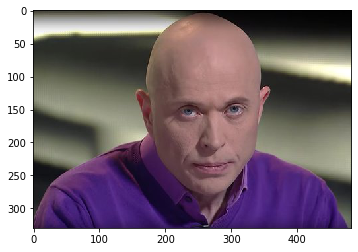

In [ ]:
from matplotlib import pyplot

img_path = "l5_face_rec/detection/druzhko.jpg"
img = pyplot.imread(img_path)
pyplot.imshow(img)
pyplot.show()

Создадим экземпляр нашей нейросети. Запишем результат разметки сети в переменную <code>results</code>

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10142704570618425437
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9919753344042156094
physical_device_desc: "device: XLA_CPU device"
]


In [ ]:
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

Запомним координаты рамки, которую нейросеть расположила вокруг лица

In [ ]:
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

Обрежем фотографию по полученной рамке

In [ ]:
face = img[y1:y2, x1:x2]

И просто посмотрим на результат =)

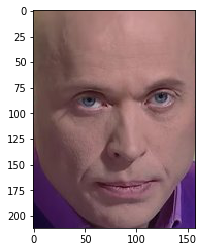

In [ ]:
from PIL import Image
import numpy as np

image = Image.fromarray(face)
face_array = np.asarray(image)
pyplot.imshow(face_array)
pyplot.show()

Отлично! Сетка работает! Давайте напишем функцию, которая делает всё то же самое, и проверим работу этой сетки на более сложных примерах.

In [ ]:
def extract_face(filename, required_size=(224, 224), resize=False):
    """Функция возвращает массив-лицо и преобразует его к заданному размеру,
    если resize == True
    
    Параметры:
    filename -- строка - путь к файлу с исходным изображением
    required_size -- кортеж из двух целых чисел - размер финального изображения
    resize -- boolean, который определяет, нужно ли менять размер изображения
    
    Возвращает np.ndarray, в котором записано обрезанное изображение с найденным
    на первоначальной картинке лицом
    """
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    """Выводит изображение на экран"""
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

Рассмотрим сложный случай: Никиту Джигурду. Длинные волосы и борода усложняют сетке поиск лица.

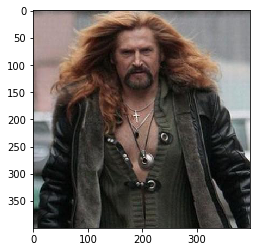

In [ ]:
print_image("l5_face_rec/detection/dzhigurda.jpg")

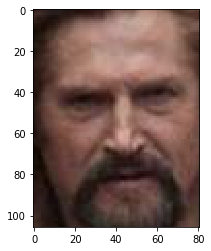

In [ ]:
print_image(extract_face("l5_face_rec/detection/dzhigurda.jpg"))

Тем не менее, всё получилось. Усложним задачу еще больше: добавим на лицо очки и прочую атрибутику.

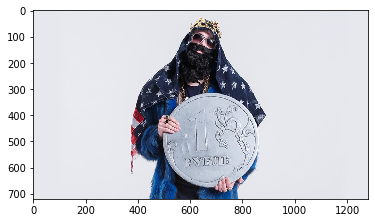

In [ ]:
print_image("l5_face_rec/detection/brb.jpg")

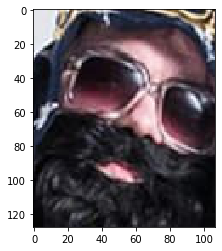

In [ ]:
print_image(extract_face("l5_face_rec/detection/brb.jpg"))

И наконец, посмотрим, как сетка продетектирует Эдди Мёрфи.

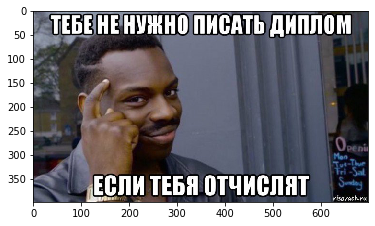

In [ ]:
print_image("l5_face_rec/detection/murphy.jpg")

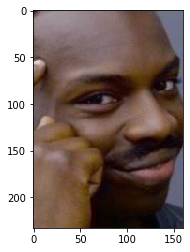

In [ ]:
print_image(extract_face("l5_face_rec/detection/murphy.jpg"))

## Распознавание лиц

В этих ваших интернетах поговаривают, что с этой задачей хорошо справляется архитектура VGGFace. Путем традиционного гуглинга найдем эту архитектуру и реализуем ее в классах keras.

In [ ]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Чтобы не собирать гигантскую выборку фотографий и не ждать до пенсии, пока пустая нейронка на ней обучится, съединороссим веса обученной модели из интернетов. Нужно скачать файл: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing

In [ ]:
from keras.models import model_from_json
model.load_weights('l5_face_rec/vgg_face_weights.h5')

Теперь нам нужно загрузить веса в сетку и зафиксировать их, т.е. сделать так, чтобы при дообучении они не изменялись.

In [ ]:
# наш выходной слой с необходимым количеством нейронов в нем
final_layer = Dense(2, activation='softmax')(model.layers[-2].output)

from keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

Скомпилируем сетку

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0  

Настало время познакомиться с нашими "подопытными". Будем обучать сетку на двух классах, т.е. на двух людях. Для этого я создал небольшие наборы данных по 20 изображений с известными актерами.

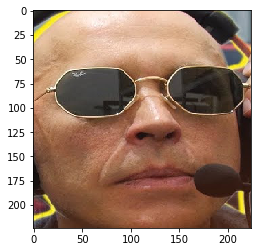

In [ ]:
pyplot.imshow(Image.fromarray(X_train[5]))
pyplot.show()

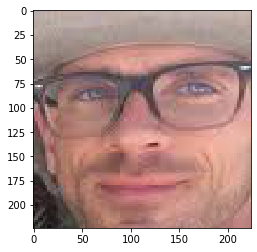

In [ ]:
pyplot.imshow(Image.fromarray(X_train[-2]))
pyplot.show()

Теперь нужно предобработать изображения. Запишем в переменные <code>files1</code> и <code>files2</code> списки файлов изображений каждого из двух классов.

In [ ]:
import os
dir1 = "l5_face_rec/recognition/druzhko/"
dir2 = "l5_face_rec/recognition/sins/"

files1 = os.listdir(dir1)
files2 = os.listdir(dir2)

Проведем детектирование лиц на каждой картинке

In [ ]:
images1 = [extract_face(os.path.join(dir1, i), resize=True)
           for i in files1]

In [ ]:
images2 = [extract_face(os.path.join(dir2, i), resize=True)
           for i in files2]

Кустарным способом сформируем тренировочную и тестовую выборки

In [ ]:
X_train = images1[:-2] + images2[:-2]
y_train = [[1, 0]] * len(images1[:-2]) + [[0, 1]] * len(images2[:-2])

X_test = images1[-2:]  + images2[-2:]
y_test = [[1, 0], [1, 0], [0, 1], [0, 1]]

Обратите внимание на формат <code>y</code>: если раньше это были просто метки классов, то теперь это список вероятностей принадлежности изображения к каждому из имеющихся классов.

Проведем аугментацию тренировочной выборки

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

Итак, выборки составлены, время обучать сетку

In [ ]:
%%time
model.fit_generator(train, epochs=100, verbose=2)

Epoch 1/100
 - 8s - loss: 0.5844 - accuracy: 0.0000e+00
Epoch 2/100
 - 8s - loss: 0.5819 - accuracy: 0.0000e+00
Epoch 3/100
 - 8s - loss: 0.5722 - accuracy: 0.0000e+00
Epoch 4/100
 - 8s - loss: 0.5819 - accuracy: 0.0000e+00
Epoch 5/100
 - 8s - loss: 0.5702 - accuracy: 0.0000e+00
Epoch 6/100
 - 9s - loss: 0.5431 - accuracy: 0.0000e+00
Epoch 7/100
 - 9s - loss: 0.5607 - accuracy: 0.0000e+00
Epoch 8/100
 - 9s - loss: 0.5586 - accuracy: 0.0000e+00
Epoch 9/100
 - 9s - loss: 0.5949 - accuracy: 0.0000e+00
Epoch 10/100
 - 9s - loss: 0.5885 - accuracy: 0.0000e+00
Epoch 11/100
 - 9s - loss: 0.5505 - accuracy: 0.0000e+00
Epoch 12/100
 - 10s - loss: 0.5040 - accuracy: 0.0000e+00
Epoch 13/100
 - 10s - loss: 0.5480 - accuracy: 0.0000e+00
Epoch 14/100
 - 10s - loss: 0.5029 - accuracy: 0.0000e+00
Epoch 15/100
 - 10s - loss: 0.5267 - accuracy: 0.0000e+00
Epoch 16/100
 - 10s - loss: 0.5283 - accuracy: 0.0000e+00
Epoch 17/100
 - 10s - loss: 0.5365 - accuracy: 0.0000e+00
Epoch 18/100
 - 10s - loss: 0.5444

In [ ]:
model.save_weights("l5_face_rec_model_weights.h5")

In [ ]:
model.load_weights("l5_face_rec_model_weights.h5")

Посмотрим на предсказания модели на тестовых данных:

In [ ]:
model.predict(np.asarray(X_test))

array([[1.0000e+00, 0.0000e+00],
       [1.0000e+00, 0.0000e+00],
       [5.7846e-38, 1.0000e+00],
       [0.0000e+00, 1.0000e+00]], dtype=float32)

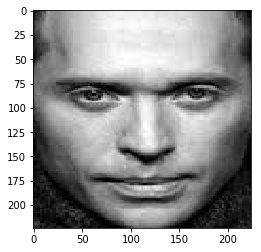

In [ ]:
pyplot.imshow(Image.fromarray(X_test[0]))
pyplot.show()

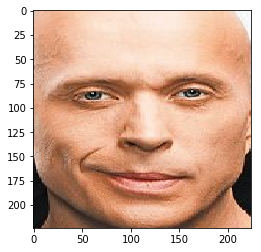

In [ ]:
pyplot.imshow(Image.fromarray(X_test[1]))
pyplot.show()

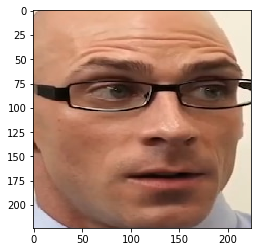

In [ ]:
pyplot.imshow(Image.fromarray(X_test[2]))
pyplot.show()

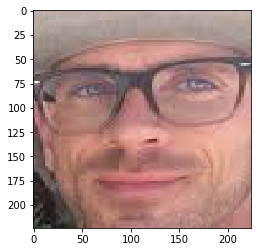

In [ ]:
pyplot.imshow(Image.fromarray(X_test[3]))
pyplot.show()